<a href="https://colab.research.google.com/github/KoderDhruv/Learning_ML/blob/main/Food_Recognition_using_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jan 23 07:46:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2023-01-23 07:46:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.5MB/s    in 7.8s    

2023-01-23 07:46:40 (20.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} folders and {len(filenames)} images in {dirpath}")

There are 2 folders and 0 images in 10_food_classes_10_percent
There are 10 folders and 0 images in 10_food_classes_10_percent/train
There are 0 folders and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 folders and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 folders and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 folders and 75 images in 10_food_classes_10_percent/train/steak
There are 0 folders and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 folders and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 folders and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 folders and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 folders and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 folders and 75 images in 10_food_classes_10_percent/train/hamburger
There are 10 folders and 0 images in 10_food_classes_10_percent/test


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_data_10_percent=train_datagen.flow_from_directory(train_dir,
                                                        batch_size=BATCH_SIZE,
                                                        target_size=IMAGE_SHAPE,
                                                        class_mode='categorical')

test_data=test_datagen.flow_from_directory(test_dir,
                                           batch_size=BATCH_SIZE,
                                           target_size=IMAGE_SHAPE,
                                           class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%y%m%d-%h%m%s")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [ ]:
def create_model(model_url, num_classes=10):
  feature_extraction_layer=hub.KerasLayer(model_url,
                                          trainable=False,
                                          name='Feature_Extraction_Layer',
                                          input_shape=IMAGE_SHAPE+(3,)) #(224,224)+(3,)=(224,224,3)

  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model

In [ ]:
resnet_model=create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_history=resnet_model.fit(train_data_10_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=len(test_data),
                                callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                       experiment_name='resnet')])

Saving Tensorboard log files to tensorflow_hub/resnet/230123-Jan011674460016
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.9750 - accuracy: 0.3480 - val_loss: 1.2617 - val_accuracy: 0.5856
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.9457 - accuracy: 0.7173 - val_loss: 0.8793 - val_accuracy: 0.7044
Epoch 3/5
24/24 [==============================] - 16s 688ms/step - loss: 0.6584 - accuracy: 0.8227 - val_loss: 0.7741 - val_accuracy: 0.7460
Epoch 4/5
24/24 [==============================] - 16s 686ms/step - loss: 0.4969 - accuracy: 0.8773 - val_loss: 0.7206 - val_accuracy: 0.7576
Epoch 5/5
24/24 [==============================] - 16s 687ms/step - loss: 0.3992 - accuracy: 0.9040 - val_loss: 0.6953 - val_accuracy: 0.7688


In [ ]:
def plot_loss_curves(history):
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs=range(len(history.history['loss']))

  plt.figure()
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.legend()

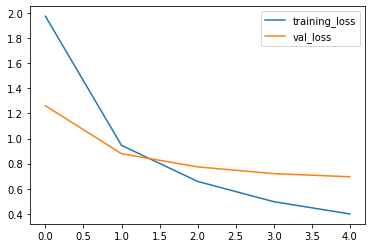

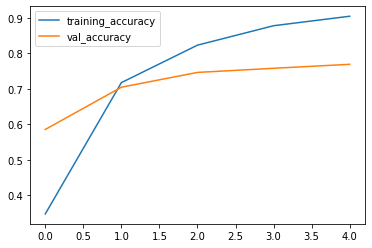

In [ ]:
import matplotlib.pyplot as plt
plot_loss_curves(resnet_history)

In [ ]:
efficientnet_model=create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnet_model')])

Saving Tensorboard log files to tensorflow_hub/efficientnet_model/230123-Jan011674460143
Epoch 1/5
24/24 [==============================] - 24s 700ms/step - loss: 1.8726 - accuracy: 0.4187 - val_loss: 1.3117 - val_accuracy: 0.6976
Epoch 2/5
24/24 [==============================] - 15s 633ms/step - loss: 1.0940 - accuracy: 0.7507 - val_loss: 0.8809 - val_accuracy: 0.8056
Epoch 3/5
24/24 [==============================] - 15s 643ms/step - loss: 0.7788 - accuracy: 0.8147 - val_loss: 0.7062 - val_accuracy: 0.8352
Epoch 4/5
24/24 [==============================] - 15s 640ms/step - loss: 0.6243 - accuracy: 0.8560 - val_loss: 0.6170 - val_accuracy: 0.8464
Epoch 5/5
24/24 [==============================] - 15s 636ms/step - loss: 0.5280 - accuracy: 0.8813 - val_loss: 0.5649 - val_accuracy: 0.8576


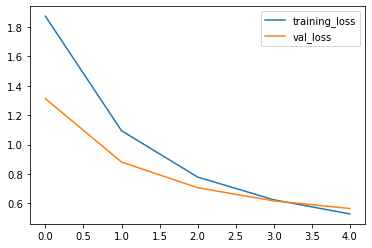

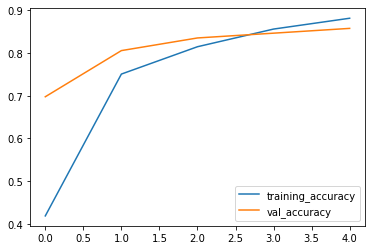

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_Extraction_Layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# !tensorboard dev upload --logdir ./tensorflow_hub/ \
#   --name "EfficientNetB0 vs. ResNet50V2" \
#   --description "..." \
#   --one_shot  

In [ ]:
# !tensorboard dev list

In [ ]:
# !tensorboard dev delete --experiment_id 4zf472VxQOGWdmb24z6JgQ

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-01-23 07:50:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-23 07:50:34 (85.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [ ]:
train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode='categorical',
                                                                          batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.12755108e+00 3.12755084e+00 0.00000000e+00]
   [4.19387817e+00 5.19387817e+00 5.96939027e-01]
   [5.58163261e+00 6.58163261e+00 1.58163261e+00]
   ...
   [3.13418388e+01 3.55561028e+01 3.85561028e+01]
   [3.42143135e+01 3.52143135e+01 4.02143135e+01]
   [3.23570023e+01 3.26427193e+01 3.79998589e+01]]

  [[3.50000048e+00 4.50000048e+00 0.00000000e+00]
   [5.92346954e+00 6.92346954e+00 1.92346966e+00]
   [6.71428585e+00 7.71428585e+00 2.71428585e+00]
   ...
   [3.00306091e+01 3.50306091e+01 3.88163452e+01]
   [2.43571548e+01 2.73571548e+01 3.43571548e+01]
   [2.78520336e+01 3.08520336e+01 3.78520355e+01]]

  [[8.14285660e+00 9.14285660e+00 4.14285707e+00]
   [5.27040815e+00 6.27040815e+00 1.27040803e+00]
   [7.16836739e+00 8.16836739e+00 3.16836739e+00]
   ...
   [2.57092133e+01 3.28775635e+01 3.87092590e+01]
   [2.30561600e+01 3.00867767e+01 3.80714684e+01]
   [3.14081669e+01 3.70460205e+01 4.59031296e+01]]

  ...

  [[2.03214096e+02 1.45214096e+02 1.22140894e+01]
   [1

In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# If using ResNet50V2, we need to normalize data first, so add in the below line of code, efficientnet has it built-in
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

layer1=base_model(inputs)
print(f'shape after passing through base_model {layer1.shape}')

layer2=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(layer1)
print(f'shape after passing through GlobalAveragePooling2D {layer2.shape}')

outputs=tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(layer2)

model_0=tf.keras.Model(inputs, outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                      experiment_name='10_percent_feature_extraction')])

16705208/16705208 [==============================] - 2s 0us/step
shape after passing through base_model (None, 7, 7, 1280)
shape after passing through GlobalAveragePooling2D (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230123-075041
Epoch 1/5
24/24 [==============================] - 11s 236ms/step - loss: 1.9101 - accuracy: 0.3827 - val_loss: 1.3570 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - 4s 151ms/step - loss: 1.1191 - accuracy: 0.7680 - val_loss: 0.8760 - val_accuracy: 0.8207
Epoch 3/5
24/24 [==============================] - 4s 150ms/step - loss: 0.8028 - accuracy: 0.8200 - val_loss: 0.6955 - val_accuracy: 0.8306
Epoch 4/5
24/24 [==============================] - 4s 149ms/step - loss: 0.6443 - accuracy: 0.8533 - val_loss: 0.5867 - val_accuracy: 0.8701
Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.5440 - accuracy: 0.8893 - val_loss: 0.5421 - val_accuracy: 0.8766


In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5638 - accuracy: 0.8620


[0.5637751817703247, 0.8619999885559082]

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
for layer_name, layer in enumerate(model_0.layers):
  print(layer_name, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

train_dir_1_percent="10_food_classes_1_percent/train"
tets_dir="10_food_classes_1_percent/test"

--2023-01-23 07:51:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  24.1MB/s    in 6.4s    

2023-01-23 07:51:34 (20.0 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [ ]:
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode='categorical',
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation=keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='augmentation_layer')


Text(0.5, 1.0, 'augmented')

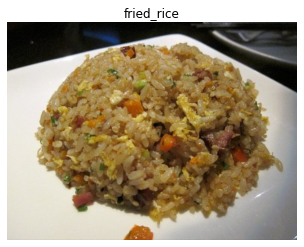

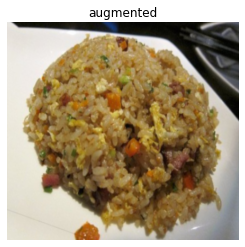

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir='10_food_classes_1_percent/train/'+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+'/'+random_image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.axis(False)
plt.title(target_class)

augmented_img=data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.axis(False)
plt.title('augmented')

In [ ]:
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape, name='input_layer')

x=data_augmentation(inputs)
x=base_model(x, training=False)
x=layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs=layers.Dense(10, activation='softmax', name='output_layer')(x)

model_1=keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1_percent=model_1.fit(train_data_1_percent, epochs=5, steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data, validation_steps=len(test_data),
                              callbacks=[create_tensorboard_callback('transfer_learning', '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230123-075138
Epoch 1/5
3/3 [==============================] - 14s 4s/step - loss: 2.2962 - accuracy: 0.1714 - val_loss: 2.1673 - val_accuracy: 0.1864
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.0898 - accuracy: 0.3429 - val_loss: 2.0394 - val_accuracy: 0.2788
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9190 - accuracy: 0.3429 - val_loss: 1.9270 - val_accuracy: 0.3732
Epoch 4/5
3/3 [==============================] - 11s 5s/step - loss: 1.7167 - accuracy: 0.5857 - val_loss: 1.8237 - val_accuracy: 0.4632
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5973 - accuracy: 0.5857 - val_loss: 1.7280 - val_accuracy: 0.5308


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# creating model checkpoint callback

checkpoint_path='ten_percent_model_checkpoints_weights/checkpoint.ckpt'

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=True,
                                                       save_freq='epoch',
                                                       verbose=1)

In [ ]:
history_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                        epochs=5, validation_data=test_data,
                                        validation_steps=len(test_data),
                                        steps_per_epoch=len(train_data_10_percent),
                                        callbacks=[create_tensorboard_callback('transfer_learning',
                                                                               '10_percent_data_aug'),
                                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230123-075231
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9880 - accuracy: 0.3547
Epoch 1: val_loss improved from inf to 1.44586, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 22s 661ms/step - loss: 1.9880 - accuracy: 0.3547 - val_loss: 1.4459 - val_accuracy: 0.7012
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3065 - accuracy: 0.7040
Epoch 2: val_loss improved from 1.44586 to 0.99666, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 15s 624ms/step - loss: 1.3065 - accuracy: 0.7040 - val_loss: 0.9967 - val_accuracy: 0.7980
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9849 - accuracy: 0.7640
Epoch 3: val_loss improved from 0.99666 to 0.78467, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [=

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6182 - accuracy: 0.8512


[0.6182487607002258, 0.8511999845504761]

In [ ]:
# loading saved weights 
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)
# little bit of change in loss but almost similar

79/79 [==============================] - 6s 70ms/step - loss: 0.6182 - accuracy: 0.8512


[0.618248701095581, 0.8511999845504761]

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
print(len(base_model.trainable_variables))

0


In [ ]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable=False

model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [ ]:
history_10_percent_data_aug.epoch

[0, 1, 2, 3, 4]

In [ ]:
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent)

24/24 [==============================] - 15s 324ms/step - loss: 0.2188 - accuracy: 0.8347


In [ ]:
history_fine_10_percent_data_aug=model_2.fit(train_data_10_percent,
                                             epochs=10,
                                             validation_data=test_data,
                                             validation_steps=int(0.25*len(test_data)),
                                             initial_epoch=history_10_percent_data_aug.epoch[-1],
                                             callbacks=[create_tensorboard_callback('transfer_learning',
                                                                                    '10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230123-075444
Epoch 5/10
24/24 [==============================] - 10s 415ms/step - loss: 0.1305 - accuracy: 0.8387 - val_loss: 0.1226 - val_accuracy: 0.8405
Epoch 6/10
24/24 [==============================] - 9s 356ms/step - loss: 0.1181 - accuracy: 0.8533 - val_loss: 0.1105 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 9s 344ms/step - loss: 0.1081 - accuracy: 0.8587 - val_loss: 0.1050 - val_accuracy: 0.8602
Epoch 8/10
24/24 [==============================] - 9s 378ms/step - loss: 0.1007 - accuracy: 0.8693 - val_loss: 0.1002 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0944 - accuracy: 0.8827 - val_loss: 0.1002 - val_accuracy: 0.8668
Epoch 10/10
24/24 [==============================] - 8s 314ms/step - loss: 0.0892 - accuracy: 0.8893 - val_loss: 0.0906 - val_accuracy: 0.8701


In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
!nvidia-smi

Mon Jan 23 07:55:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    33W /  70W |   9074MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


unzip_data('101_food_classes_10_percent.zip')
train_dir='101_food_classes_10_percent/train/'
test_dir='101_food_classes_10_percent/test/'

--2023-01-23 07:55:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  23.9MB/s    in 67s     

2023-01-23 07:56:52 (23.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/falafel'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pork_chop'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images i

In [ ]:
import tensorflow as tf
IMG_SIZE=(224,224)

train_data_all_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                              label_mode='categorical',
                                                                              image_size=IMG_SIZE) 
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE,
                                                              shuffle=False) 

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
checkpoint_path='101_classes_10_percent_data_model_checkpoint'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor='val_accuracy',
                                                       sabe_best_only=True)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation=Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name='augmentation_layer')


In [ ]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=(224,224,3), name='input_layer')
x=data_augmentation(inputs)
x=base_model(x, training=False)
x=layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)

model=tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 augmentation_layer (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                                         epochs=5,
                                         validation_data=test_data,
                                         validation_steps=int(0.15*len(test_data)),
                                         callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 70s 272ms/step - loss: 3.3882 - accuracy: 0.2739 - val_loss: 2.4847 - val_accuracy: 0.4751
Epoch 2/5
237/237 [==============================] - 56s 237ms/step - loss: 2.1972 - accuracy: 0.5014 - val_loss: 2.0347 - val_accuracy: 0.5124
Epoch 3/5
237/237 [==============================] - 53s 222ms/step - loss: 1.8167 - accuracy: 0.5720 - val_loss: 1.8704 - val_accuracy: 0.5355
Epoch 4/5
237/237 [==============================] - 51s 214ms/step - loss: 1.6105 - accuracy: 0.6055 - val_loss: 1.7881 - val_accuracy: 0.5466
Epoch 5/5
237/237 [==============================] - 49s 206ms/step - loss: 1.4606 - accuracy: 0.6455 - val_loss: 1.7864 - val_accuracy: 0.5440


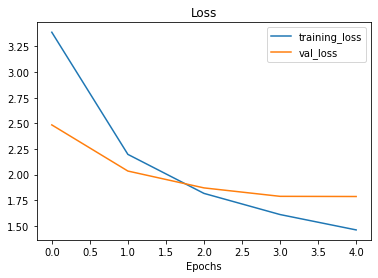

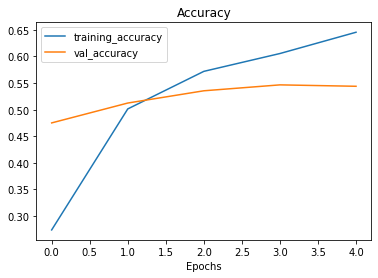

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

In [ ]:
base_model.trainable=True
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
augmentation_layer True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [ ]:
fine_tune_epochs=10
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                                                   epochs=fine_tune_epochs,
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 55s 206ms/step - loss: 0.0421 - accuracy: 0.6632 - val_loss: 0.0334 - val_accuracy: 0.5413
Epoch 6/10
237/237 [==============================] - 46s 191ms/step - loss: 0.0253 - accuracy: 0.6816 - val_loss: 0.0313 - val_accuracy: 0.5360
Epoch 7/10
237/237 [==============================] - 44s 184ms/step - loss: 0.0228 - accuracy: 0.7043 - val_loss: 0.0303 - val_accuracy: 0.5392
Epoch 8/10
237/237 [==============================] - 45s 189ms/step - loss: 0.0212 - accuracy: 0.7179 - val_loss: 0.0297 - val_accuracy: 0.5487
Epoch 9/10
237/237 [==============================] - 44s 182ms/step - loss: 0.0201 - accuracy: 0.7331 - val_loss: 0.0289 - val_accuracy: 0.5538
Epoch 10/10
237/237 [==============================] - 41s 172ms/step - loss: 0.0193 - accuracy: 0.7399 - val_loss: 0.0292 - val_accuracy: 0.5522


In [ ]:
all_classes_10_percent_fine_tune_result=model.evaluate(test_data)
all_classes_10_percent_fine_tune_result

790/790 [==============================] - 57s 72ms/step - loss: 0.0260 - accuracy: 0.5966


[0.025973018258810043, 0.5965544581413269]

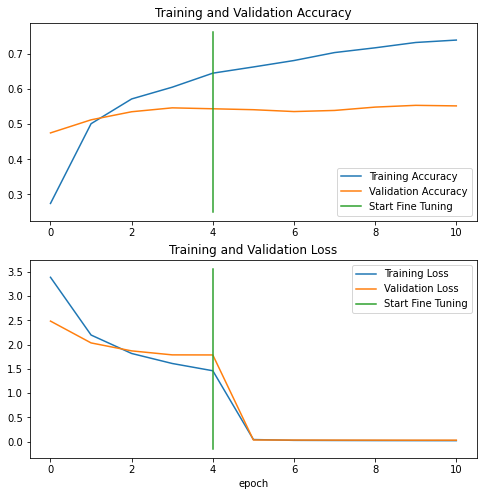

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
preds_probs=model.predict(test_data, verbose=1)

790/790 [==============================] - 60s 74ms/step


In [ ]:
preds_probs[0].argmax()

2

In [ ]:
train_data_all_10_percent.class_names[2]

'baklava'

In [ ]:
pred_classes=preds_probs.argmax(axis=1)
pred_classes[:10]

array([ 2,  0,  0,  8,  8, 78, 29, 72,  2,  0])

In [ ]:
y_labels=[]
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5965544554455445

In [ ]:
class_names=test_data.class_names
class_names[:12]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad']

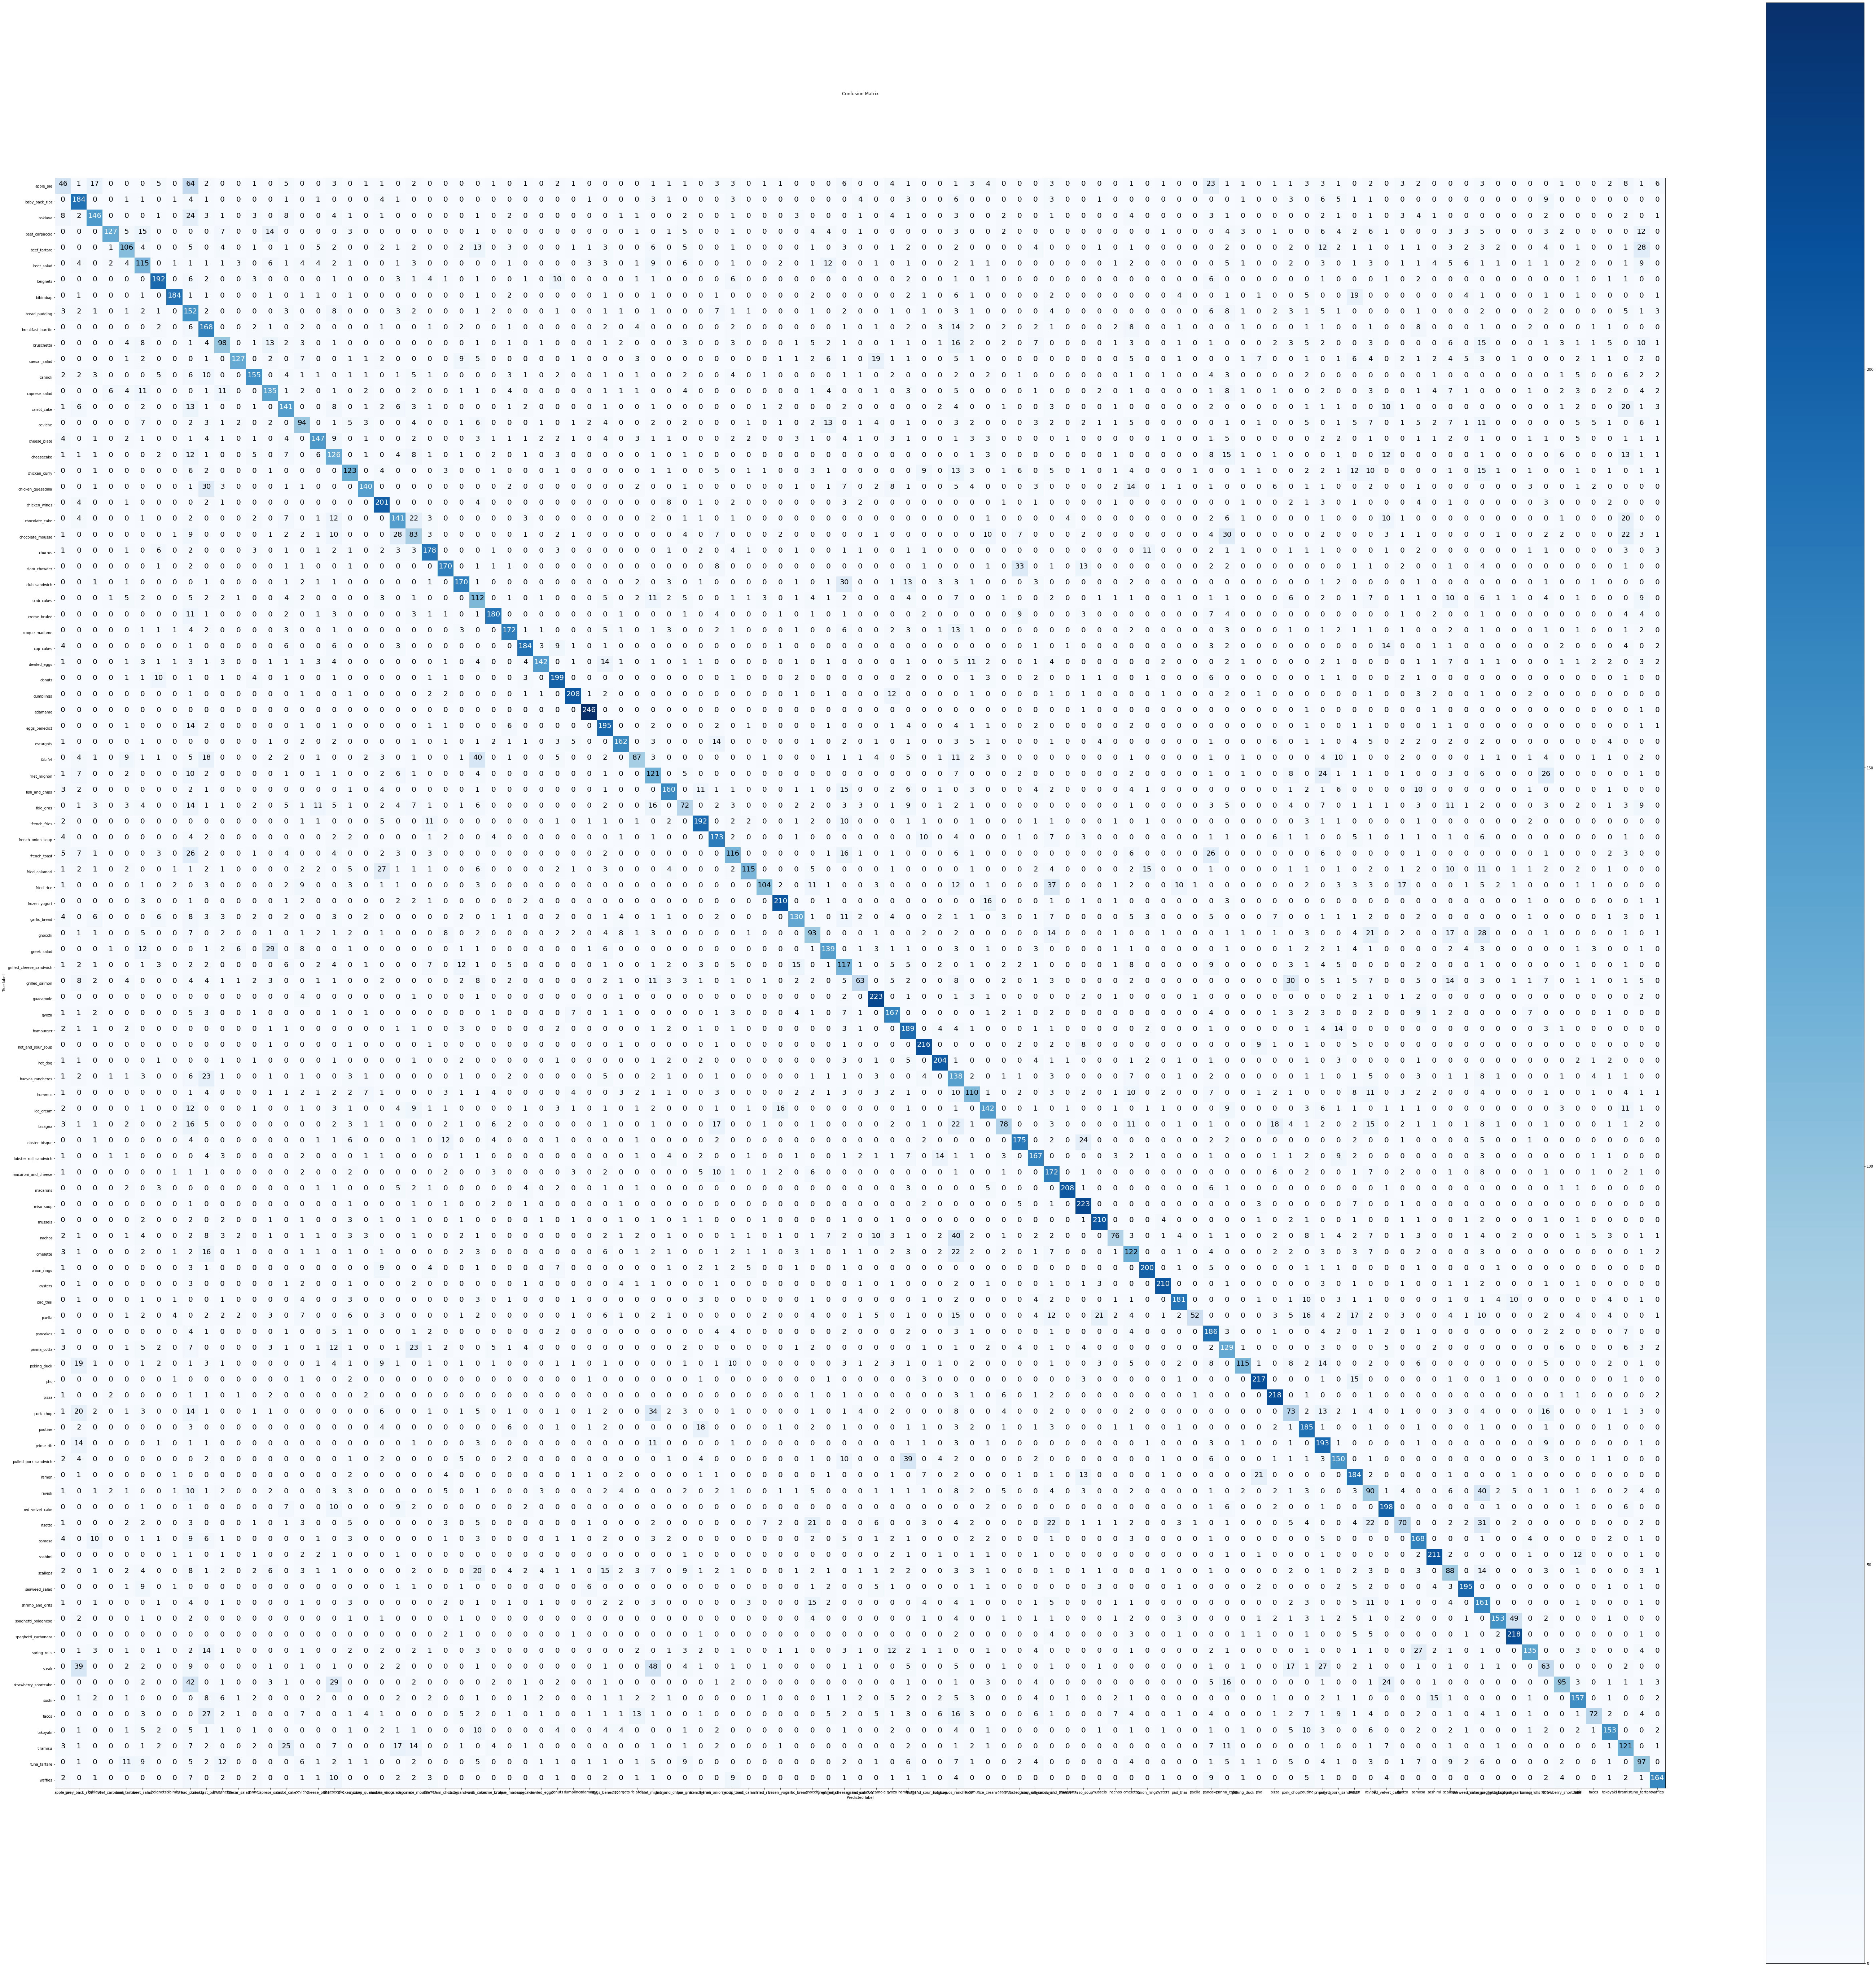

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.34      0.18      0.24       250
           1       0.51      0.74      0.60       250
           2       0.68      0.58      0.63       250
           3       0.88      0.51      0.64       250
           4       0.55      0.42      0.48       250
           5       0.43      0.46      0.44       250
           6       0.75      0.77      0.76       250
           7       0.89      0.74      0.81       250
           8       0.23      0.61      0.34       250
           9       0.39      0.67      0.50       250
          10       0.52      0.39      0.45       250
          11       0.86      0.51      0.64       250
          12       0.76      0.62      0.68       250
          13       0.56      0.54      0.55       250
          14       0.52      0.56      0.54       250
          15       0.46      0.38      0.41       250
          16       0.70      0.59      0.64       250
          17       0.39    

In [ ]:
classification_report_dict=classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.3382352941176471,
  'recall': 0.184,
  'f1-score': 0.23834196891191708,
  'support': 250},
 '1': {'precision': 0.5096952908587258,
  'recall': 0.736,
  'f1-score': 0.602291325695581,
  'support': 250},
 '2': {'precision': 0.6790697674418604,
  'recall': 0.584,
  'f1-score': 0.6279569892473118,
  'support': 250},
 '3': {'precision': 0.8819444444444444,
  'recall': 0.508,
  'f1-score': 0.6446700507614213,
  'support': 250},
 '4': {'precision': 0.5492227979274611,
  'recall': 0.424,
  'f1-score': 0.4785553047404063,
  'support': 250},
 '5': {'precision': 0.4275092936802974,
  'recall': 0.46,
  'f1-score': 0.4431599229287091,
  'support': 250},
 '6': {'precision': 0.75,
  'recall': 0.768,
  'f1-score': 0.7588932806324111,
  'support': 250},
 '7': {'precision': 0.8932038834951457,
  'recall': 0.736,
  'f1-score': 0.8070175438596492,
  'support': 250},
 '8': {'precision': 0.2345679012345679,
  'recall': 0.608,
  'f1-score': 0.3385300668151447,
  'support': 250},
 '9': {

In [ ]:
class_f1_scores = {}

for k,v in classification_report_dict.items():
  if k=='accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]]=v['f1-score']

class_f1_scores

{'apple_pie': 0.23834196891191708,
 'baby_back_ribs': 0.602291325695581,
 'baklava': 0.6279569892473118,
 'beef_carpaccio': 0.6446700507614213,
 'beef_tartare': 0.4785553047404063,
 'beet_salad': 0.4431599229287091,
 'beignets': 0.7588932806324111,
 'bibimbap': 0.8070175438596492,
 'bread_pudding': 0.3385300668151447,
 'breakfast_burrito': 0.49630723781388475,
 'bruschetta': 0.4454545454545455,
 'caesar_salad': 0.6381909547738693,
 'cannoli': 0.6828193832599119,
 'caprese_salad': 0.5510204081632654,
 'carrot_cake': 0.5423076923076923,
 'ceviche': 0.41318681318681316,
 'cheese_plate': 0.6405228758169934,
 'cheesecake': 0.43749999999999994,
 'chicken_curry': 0.5256410256410257,
 'chicken_quesadilla': 0.6557377049180328,
 'chicken_wings': 0.7077464788732394,
 'chocolate_cake': 0.5540275049115913,
 'chocolate_mousse': 0.34439834024896265,
 'churros': 0.725050916496945,
 'clam_chowder': 0.7068607068607069,
 'club_sandwich': 0.6952965235173824,
 'crab_cakes': 0.4050632911392405,
 'creme_brul

In [ ]:
import pandas as pd
f1_scores=pd.DataFrame({'class_names': list(class_f1_scores.keys()),
                       'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)
f1_scores

class_names  f1-score
33        edamame  0.947977
63       macarons  0.890792
69        oysters  0.869565
45  frozen_yogurt  0.843373
32      dumplings  0.837022
..            ...       ...
8   bread_pudding  0.338530
82        ravioli  0.315236
77      pork_chop  0.313305
93          steak  0.280624
0       apple_pie  0.238342

[101 rows x 2 columns]

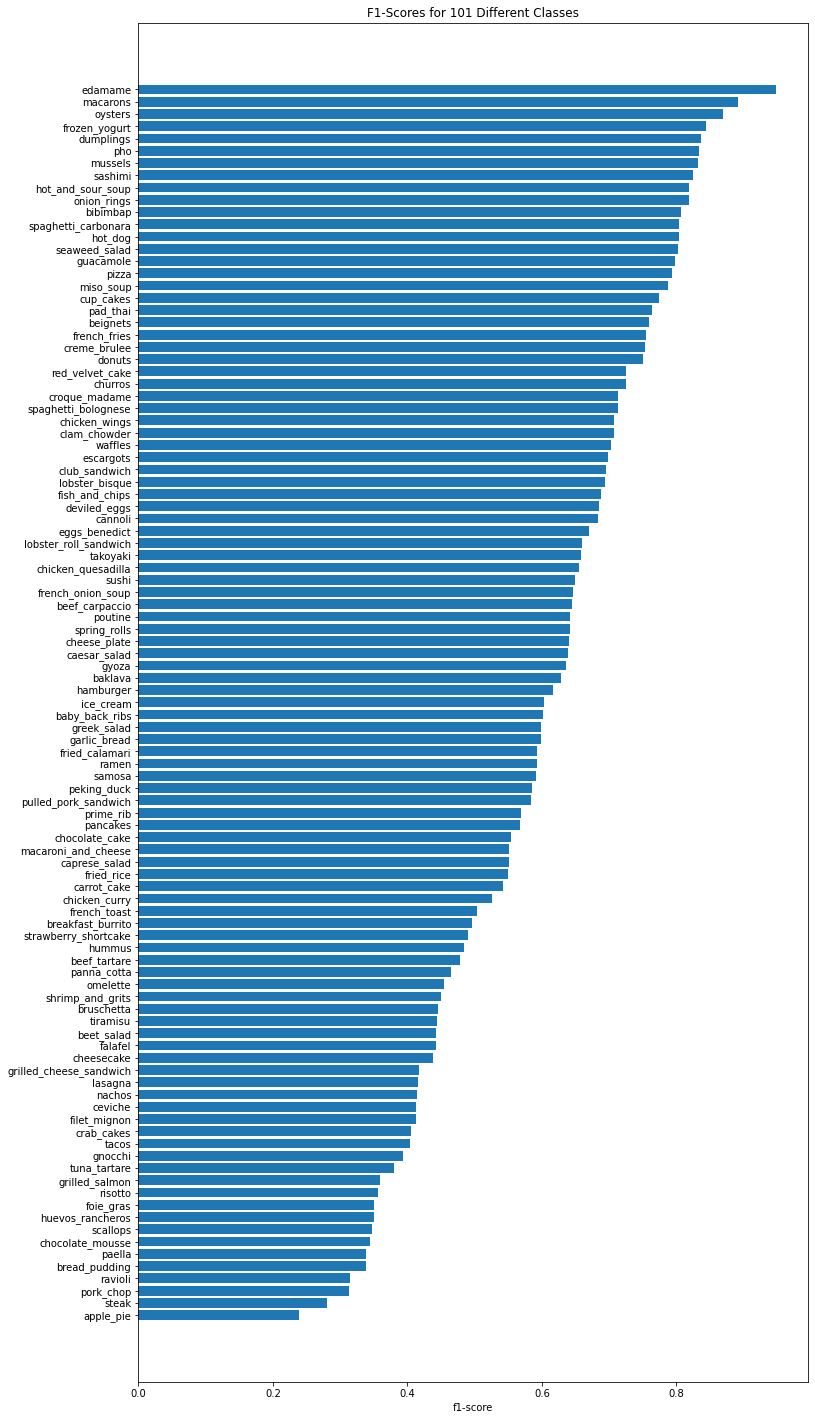

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis();

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  img=tf.io.read_file(filename)
  img=tf.io.decode_image(img, channels=3)

  img=tf.image.resize(img, [img_shape, img_shape]) 
  if scale:
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 22ms/step


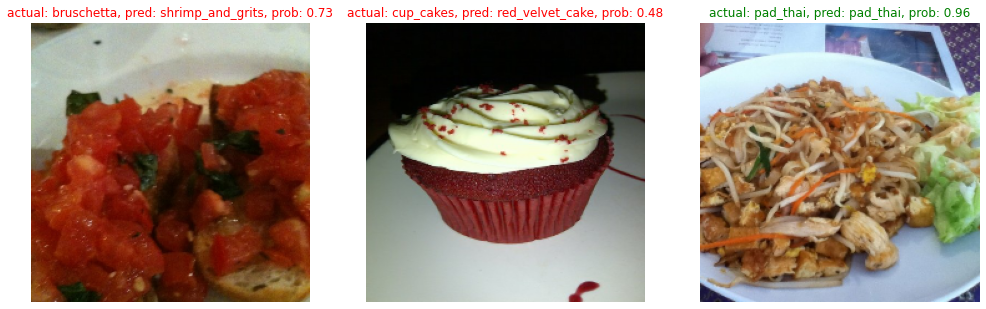

In [ ]:
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+'/'+class_name))
  filepath=test_dir+class_name+'/'+filename
  img=load_and_prep_image(filepath, scale=False)
  pred_prob=model.predict(tf.expand_dims(img, axis=0))
  pred_class=class_names[pred_prob.argmax()]

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name==pred_class:
    title_color='g'
  else:
    title_color='r'
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

In [ ]:
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", 
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]}) 
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.147013        apple_pie          baklava  
1   0.957596        apple_pie        apple_pie  
2   0.600119        apple_pie        apple_pie  
3   0.307781        apple_pie    bread_pudding  
4   0.690547        apple_pie    bread_pudding

In [ ]:
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       2   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.147013        apple_pie          baklava         False  
1   0.957596        apple_pie        apple_pie          True  
2   0.600119        apple_pie        apple_pie          True  
3   0.307781        apple_pie    bread_pudding         False  
4   0.690547        apple_pie    bread_pudding         False

In [ ]:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
4583   b'101_food_classes_10_percent/test/chicken_cur...      18      60   
10947  b'101_food_classes_10_percent/test/fried_calam...      43      68   
10346  b'101_food_classes_10_percent/test/french_onio...      41      54   
14630  b'101_food_classes_10_percent/test/ice_cream/3...      58      78   
22684  b'101_food_classes_10_percent/test/spaghetti_b...      90      91   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
22606  b'101_food_classes_10_percent/test/spaghetti_b...      90       1   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
14691  b'101_food_classes_10_percent/test/ice_cream/3...      58      79   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
10277  b'101_food_classes_10_percent/test/french_onio...      41      54   
15437  b'101_food_classes_10_percent/test/lobster_rol...      61      55   
10783  b'101_food_classes_10_percent/test/fried_calam...      43      20   
24479  b'101_food_classes_10_percent/test/takoyaki/68...      97      78   
11146  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   

       pred_conf       y_true_classname     y_pred_classname  pred_correct  
10847   0.999464         fried_calamari          onion_rings         False  
23797   0.997585                  sushi              sashimi         False  
11642   0.997534           garlic_bread           bruschetta         False  
4583    0.997450          chicken_curry       lobster_bisque         False  
10947   0.997407         fried_calamari          onion_rings         False  
10346   0.997172      french_onion_soup    hot_and_sour_soup         False  
14630   0.996770              ice_cream              poutine         False  
22684   0.996478    spaghetti_bolognese  spaghetti_carbonara         False  
23300   0.995976                  steak       baby_back_ribs         False  
22606   0.995741    spaghetti_bolognese       baby_back_ribs         False  
15142   0.995622         lobster_bisque            miso_soup         False  
18001   0.995573               pancakes             omelette         False  
14691   0.995245              ice_cream            prime_rib         False  
15359   0.995107  lobster_roll_sandwich            hamburger         False  
10277   0.995063      french_onion_soup    hot_and_sour_soup         False  
15437   0.994355  lobster_roll_sandwich              hot_dog         False  
10783   0.994072         fried_calamari        chicken_wings         False  
24479   0.993683               takoyaki              poutine         False  
11146   0.993262             fried_rice  macaroni_and_cheese         False  
14482   0.993151                 hummus            guacamole         False

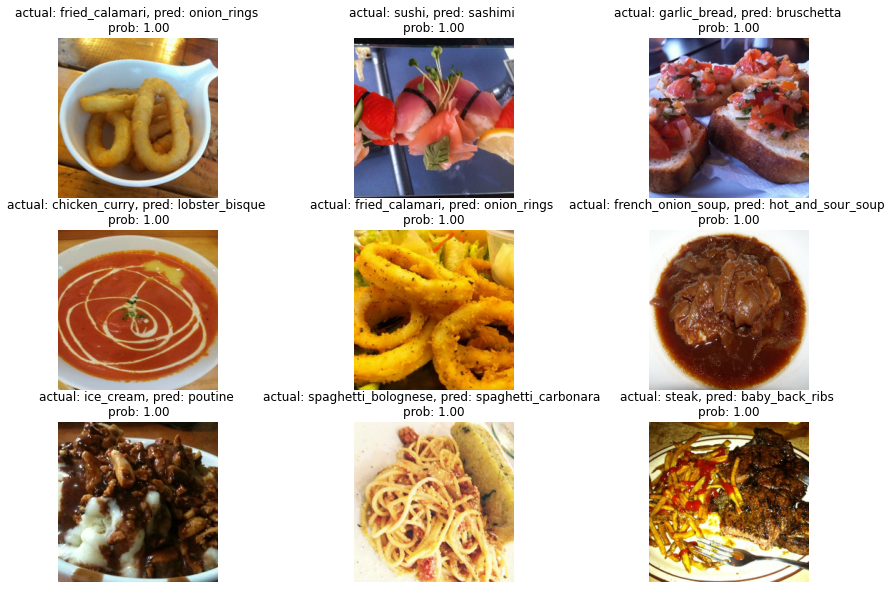

In [ ]:
images_to_view = 9
start_index = 0 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") 

--2023-01-23 08:11:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  5.81MB/s    in 2.2s    

2023-01-23 08:11:13 (5.81 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg']

1/1 [==============================] - 0s 24ms/step


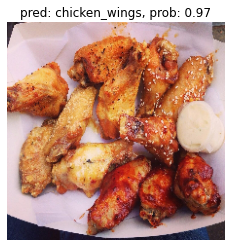

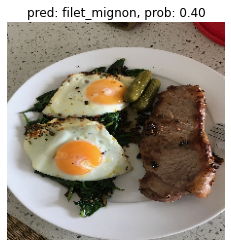

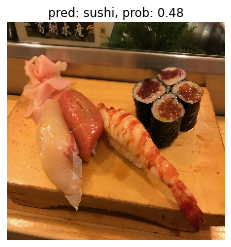

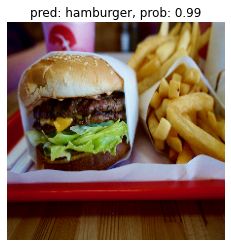

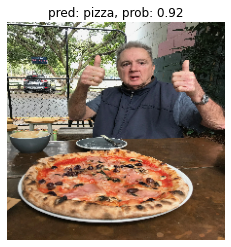

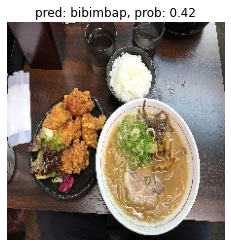

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)